# March Madness Bracket Predictor

### The objective of this project is to use machine learning models in order to predict the outcomes of March Madness games, then using these predictions to generate a bracket. 

*This project is a work in progress. The initial goal is to get a minimum working example and then progressively improve the results via data exploration, additional models, further hyperparameter tuning, etc.*

## Outline:
1. Problem Definition
2. Data Explaination
3. Evaluation
4. Feature Selection
5. Modeling
6. Results and Summary

## 1. Problem Definition
March Madness is the post season, 64-team bracket for (Men's) NCAA Basketball. The winner of the tournament is deemed the national champion. It is common practice to individually fill out these brackets prior to the start of the first game. The objective of this project is to predict the outcome of a game between two selected teams, this infomation will then be used to generate an entire bracket of predictions.

In [2]:
#Basic imports, they were added as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

We will utilize the above attributes to represent each team. For each game, we represent the winner by their stat vector $W = \langle \text{seed, wins, losses,} \dots \text{, pf, pfpg}\rangle$. We represent the loser, $L$ in a similar fashion. Each game is then morphed into two feature vectors: $\langle W - L, 1 \rangle$ and $\langle L - W, 0 \rangle$ to properly account for substraction not being a commutative operation.

In [4]:
df = pd.read_csv("current-feature-vectors.csv")

cols_to_drop = ['team0', 'team1',
             'losses', 'winp', 'cwins',
             'closses', 'pts', 'fgm',
             'fga', '3pm', '3pa',
             'ftm', 'fta', 'orb',
             'orbpg', 'drb', 'drbpg',
             'reb', 'ast', 'stl',
             'blk', 'tov', 'pf']

current_feature_vectors = df.drop(cols_to_drop, axis=1)
current_feature_vectors

,year,seed,wins,cwinp,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg
0,2022,-15,7,0.286,23.028,0.121,0.040,-0.007,6.835,5.967,-2.038,1.667,0.617,0.495
1,2022,-1,4,0.111,-9.735,-0.024,-0.009,-0.044,-4.617,-5.104,-2.759,-2.277,-4.556,-4.561
2,2022,-7,-5,-0.081,0.156,-0.019,0.022,0.051,0.469,-0.156,0.813,2.313,-2.813,0.500
3,2022,-9,-2,-0.222,8.061,-0.058,-0.061,0.018,6.212,-0.091,3.273,2.091,3.818,4.515
4,2022,-5,-6,-0.250,2.594,-0.023,-0.072,-0.025,3.406,-0.219,1.593,2.813,3.625,5.093
5,2022,-11,-2,-0.133,-0.353,-0.001,-0.047,-0.056,2.706,1.294,3.324,0.059,1.411,-1.206
6,2022,-3,-5,-0.283,-1.288,-0.025,-0.009,-0.004,3.167,1.527,1.271,2.657,3.439,2.639
7,2022,-13,6,0.094,19.598,0.046,0.037,-0.028,8.860,7.269,-0.192,4.409,-0.751,-0.676
8,2022,-15,1,-0.079,5.111,0.001,0.000,-0.002,-0.589,4.071,2.412,-0.044,-1.344,-1.108
9,2022,-1,8,0.171,18.519,-0.003,0.014,0.023,13.858,1.704,-1.751,-0.573,1.446,-0.310


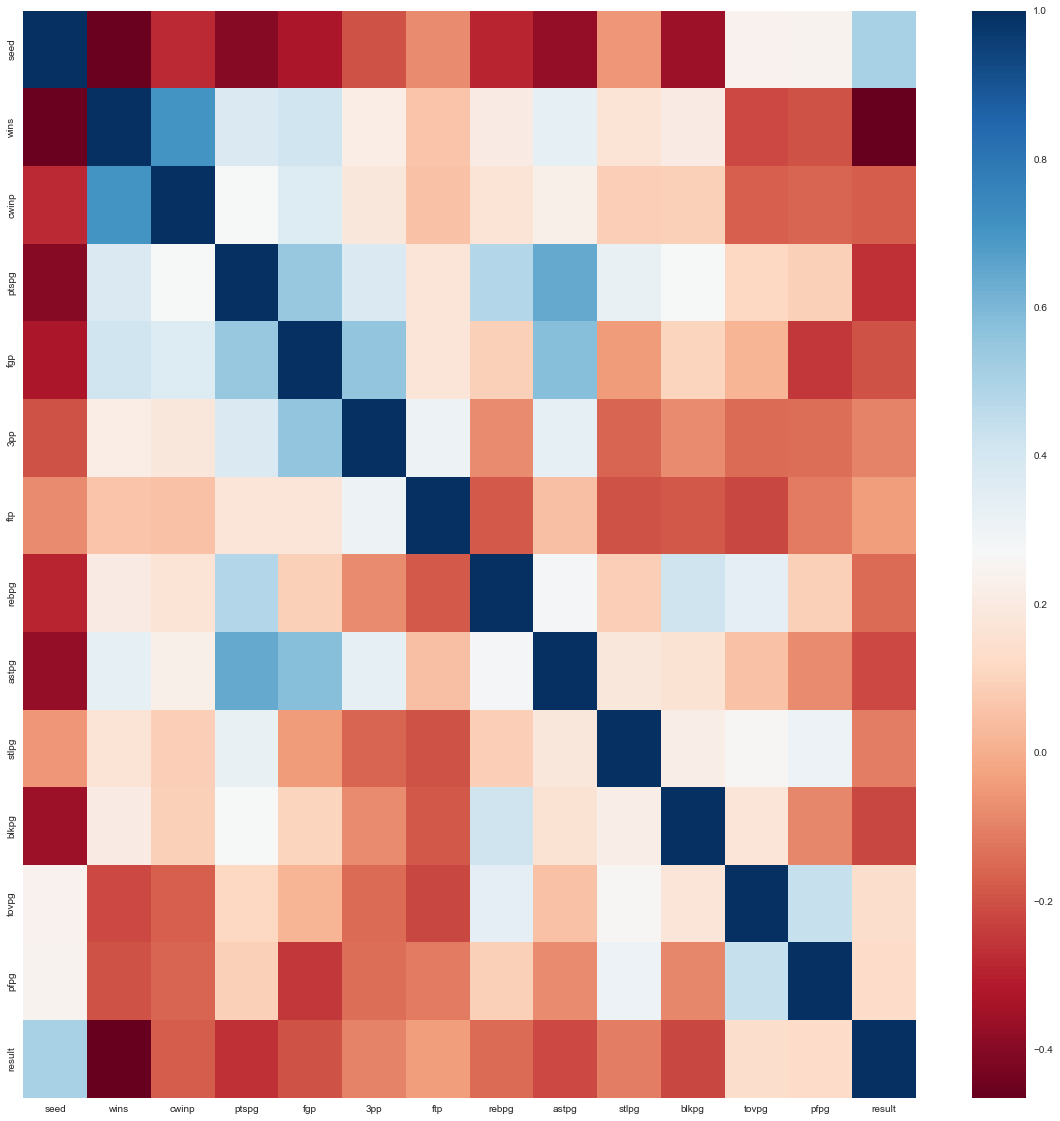

In [61]:
plt.figure(figsize=(20,20))
corr_matrix = feature_vectors.drop("year", axis=1).corr()
sns.heatmap(corr_matrix, annot=False, cmap="RdBu");

In [62]:
df_train = feature_vectors
df_train = df_train.drop("year", axis=1)
df_train = df_train.sample(frac=1)
df_train

,seed,wins,cwinp,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,result
639,-5,-1,-0.014,-9.615,0.038,0.063,-0.004,-6.992,-3.465,-1.989,0.825,-0.664,-4.315,1
551,7,-8,-0.313,-4.910,-0.011,-0.025,0.033,-4.838,-0.890,-2.943,-1.864,0.399,-2.803,1
102,-3,2,0.063,-8.290,0.005,0.039,0.052,-7.774,0.355,0.258,-3.000,0.097,2.129,0
222,-9,-4,-0.188,-2.506,0.010,0.039,-0.021,-0.964,0.523,-3.794,-0.873,-3.948,2.492,0
2017,15,-9,-0.222,-9.217,-0.011,-0.014,-0.001,-9.264,-5.844,-0.401,-0.764,-0.749,0.036,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,3,-6,-0.216,-0.953,-0.031,-0.030,0.016,-2.103,-2.702,1.447,0.774,0.388,3.355,1
125,-1,-1,0.063,2.520,0.023,0.011,-0.024,1.351,2.210,1.877,-2.242,1.337,-0.246,1
1496,-3,-4,-0.167,-7.932,-0.029,-0.050,-0.022,1.079,-3.776,-0.787,0.642,-1.302,-1.439,0
357,13,-2,-0.187,-0.666,0.019,0.014,0.009,21.400,0.266,-1.833,-0.433,1.633,2.400,1


In [63]:
X_train = df_train.drop("result", axis=1)
y_train = df_train["result"]

In [21]:

df_test = feature_vectors[feature_vectors["year"] == 2022]
df_test

,year,seed,wins,cwinp,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,result
2142,2022,-15,8,0.286,17.221,0.124,0.050,0.013,3.610,4.671,-2.274,1.295,-0.133,-0.336,0
2143,2022,15,-8,-0.286,-17.221,-0.124,-0.050,-0.013,-3.610,-4.671,2.274,-1.295,0.133,0.336,1
2144,2022,1,-6,-0.111,6.713,0.023,0.011,0.043,2.950,4.536,2.798,2.177,4.205,3.651,0
2145,2022,-1,6,0.111,-6.713,-0.023,-0.011,-0.043,-2.950,-4.536,-2.798,-2.177,-4.205,-3.651,1
2146,2022,7,3,0.081,-1.876,0.021,-0.027,-0.052,-1.625,0.000,-0.907,-2.344,2.125,-0.937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2022,-6,4,0.050,2.661,0.036,0.006,-0.043,-1.361,2.094,1.077,1.711,-1.401,-0.717,1
2264,2022,-1,2,-0.022,5.952,0.044,-0.004,-0.099,2.335,3.380,0.170,1.905,2.529,0.611,0
2265,2022,1,-2,0.022,-5.952,-0.044,0.004,0.099,-2.335,-3.380,-0.170,-1.905,-2.529,-0.611,1
2266,2022,-7,4,0.028,1.073,0.028,-0.007,-0.048,-2.302,0.623,1.018,0.329,0.893,1.489,0


In [66]:
df_test = pd.read_csv("current-feature-vectors.csv")
df_test = df_test.drop("year", axis=1)
df_test

,team0,team1,seed,wins,losses,winp,cwins,closses,cwinp,pts,...,ast,astpg,stl,stlpg,blk,blkpg,tov,tovpg,pf,pfpg
0,Gonzaga,Georgia State,-15,7,-6,0.219,4,-4,0.286,741,...,187,5.967,-50,-2.038,53,1.667,30,0.617,31,0.495
1,Boise State,Memphis,-1,4,-1,0.055,2,-2,0.111,-91,...,-123,-5.104,-67,-2.759,-60,-2.277,-104,-4.556,-95,-4.561
2,Connecticut,New Mexico State,-7,-5,5,-0.156,0,2,-0.081,5,...,-5,-0.156,26,0.813,74,2.313,-90,-2.813,16,0.500
3,Arkansas,Vermont,-9,-2,2,-0.060,-4,4,-0.222,266,...,-3,-0.091,108,3.273,69,2.091,126,3.818,149,4.515
4,Alabama,Notre Dame,-5,-6,6,-0.188,-6,4,-0.250,83,...,-7,-0.219,51,1.593,90,2.813,116,3.625,163,5.093
5,Texas Tech,Montana State,-11,-2,2,-0.059,-4,2,-0.133,-12,...,44,1.294,113,3.324,2,0.059,48,1.411,-41,-1.206
6,Michigan State,Davidson,-3,-5,6,-0.171,-4,6,-0.283,34,...,67,1.527,48,1.271,93,2.657,127,3.439,105,2.639
7,Duke,Cal State Fullerton,-13,6,-3,0.117,4,-1,0.094,883,...,282,7.269,16,-0.192,156,4.409,12,-0.751,26,-0.676
8,Baylor,Norfolk State,-15,1,1,-0.019,2,2,-0.079,317,...,156,4.071,91,2.412,6,-0.044,-14,-1.344,1,-1.108
9,North Carolina,Marquette,-1,8,-7,0.231,4,-3,0.171,669,...,71,1.704,-48,-1.751,-13,-0.573,59,1.446,8,-0.310


In [10]:
X_test = df_test.drop("result", axis=1)
y_test = df_test["result"]

In [11]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [12]:
clf.score(X_test, y_test)

0.6984126984126984

In [13]:
y_preds = clf.predict(X_test)
y_preds

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1])

In [47]:
df

,year,team0,team1,seed,wins,losses,winp,cwins,closses,cwinp,...,astpg,stl,stlpg,blk,blkpg,tov,tovpg,pf,pfpg,result
0,2003,Kentucky,IUPUI,-15,8,-9,0.269,6,-4,0.286,...,2.886,-34.0,-0.795,106.0,3.370,-71.0,-1.728,-84.0,-2.018,0
1,2003,IUPUI,Kentucky,15,-8,9,-0.269,-6,4,-0.286,...,-2.886,34.0,0.795,-106.0,-3.370,71.0,1.728,84.0,2.018,1
2,2003,Utah,Oregon,1,1,-2,0.055,1,-5,0.230,...,-4.211,-108.0,-3.225,29.0,1.025,-100.0,-2.738,-53.0,-1.034,0
3,2003,Oregon,Utah,-1,-1,2,-0.055,-1,5,-0.230,...,4.211,108.0,3.225,-29.0,-1.025,100.0,2.738,53.0,1.034,1
4,2003,Wisconsin,Weber State,-7,-4,2,-0.080,-2,4,-0.250,...,-0.918,-4.0,0.323,58.0,2.054,-88.0,-2.165,-151.0,-3.914,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2022,Duke,North Carolina,-6,4,-3,0.097,1,-1,0.050,...,2.094,42.0,1.077,62.0,1.711,-36.0,-1.401,-10.0,-0.717,1
2264,2022,Kansas,Villanova,-1,2,-1,0.036,-2,0,-0.022,...,3.380,12.0,0.170,67.0,1.905,96.0,2.529,36.0,0.611,0
2265,2022,Villanova,Kansas,1,-2,1,-0.036,2,0,0.022,...,-3.380,-12.0,-0.170,-67.0,-1.905,-96.0,-2.529,-36.0,-0.611,1
2266,2022,Kansas,North Carolina,-7,4,-3,0.097,-1,-1,0.028,...,0.623,40.0,1.018,15.0,0.329,42.0,0.893,65.0,1.489,0


In [55]:
blah = pd.read_csv(f"brackets/2022-bracket.csv")
b = blah[blah["year"] == 2022]
b = blah[blah["round"] == 1.0]
b = b[["year", "team0", "team1", "region"]]
b
b.to_csv("test-input.csv", index=False)

In [41]:
r = results.iloc[::2]
r.head(50)

,team0,team1,result,pred
2142,Gonzaga,Georgia State,0,0
2144,Memphis,Boise State,0,1
2146,New Mexico State,Connecticut,0,1
2148,Arkansas,Vermont,0,0
2150,Notre Dame,Alabama,0,1
2152,Texas Tech,Montana State,0,0
2154,Michigan State,Davidson,0,0
2156,Duke,Cal State Fullerton,0,0
2158,Gonzaga,Memphis,0,0
2160,Arkansas,New Mexico State,0,0


In [31]:
results = df[df["year"] == 2022]
results = results[["team0", "team1", "result"]]
results["pred"] = y_preds
results[results["result"] != results["pred"]]

,team0,team1,result,pred
2144,Memphis,Boise State,0,1
2145,Boise State,Memphis,1,0
2146,New Mexico State,Connecticut,0,1
2147,Connecticut,New Mexico State,1,0
2150,Notre Dame,Alabama,0,1
2151,Alabama,Notre Dame,1,0
2166,Arkansas,Gonzaga,0,1
2167,Gonzaga,Arkansas,1,0
2186,Saint Peter's,Kentucky,0,1
2187,Kentucky,Saint Peter's,1,0


In [19]:
df_test

,seed,wins,cwinp,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,result
2142,-15,8,0.286,17.221,0.124,0.050,0.013,3.610,4.671,-2.274,1.295,-0.133,-0.336,0
2143,15,-8,-0.286,-17.221,-0.124,-0.050,-0.013,-3.610,-4.671,2.274,-1.295,0.133,0.336,1
2144,1,-6,-0.111,6.713,0.023,0.011,0.043,2.950,4.536,2.798,2.177,4.205,3.651,0
2145,-1,6,0.111,-6.713,-0.023,-0.011,-0.043,-2.950,-4.536,-2.798,-2.177,-4.205,-3.651,1
2146,7,3,0.081,-1.876,0.021,-0.027,-0.052,-1.625,0.000,-0.907,-2.344,2.125,-0.937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,-6,4,0.050,2.661,0.036,0.006,-0.043,-1.361,2.094,1.077,1.711,-1.401,-0.717,1
2264,-1,2,-0.022,5.952,0.044,-0.004,-0.099,2.335,3.380,0.170,1.905,2.529,0.611,0
2265,1,-2,0.022,-5.952,-0.044,0.004,0.099,-2.335,-3.380,-0.170,-1.905,-2.529,-0.611,1
2266,-7,4,0.028,1.073,0.028,-0.007,-0.048,-2.302,0.623,1.018,0.329,0.893,1.489,0


In [16]:
X_test.head()

,seed,wins,cwinp,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg
2142,-15,8,0.286,17.221,0.124,0.050,0.013,3.610,4.671,-2.274,1.295,-0.133,-0.336
2143,15,-8,-0.286,-17.221,-0.124,-0.050,-0.013,-3.610,-4.671,2.274,-1.295,0.133,0.336
2144,1,-6,-0.111,6.713,0.023,0.011,0.043,2.950,4.536,2.798,2.177,4.205,3.651
2145,-1,6,0.111,-6.713,-0.023,-0.011,-0.043,-2.950,-4.536,-2.798,-2.177,-4.205,-3.651
2146,7,3,0.081,-1.876,0.021,-0.027,-0.052,-1.625,0.000,-0.907,-2.344,2.125,-0.937


In [15]:
y_test.head()

2142    0
2143    1
2144    0
2145    1
2146    0
Name: result, dtype: int64

In [17]:
test = X_test
test["result"] = y_test
test["pred"] = y_preds

In [18]:
test

,seed,wins,cwinp,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,result,pred
2142,-15,8,0.286,17.221,0.124,0.050,0.013,3.610,4.671,-2.274,1.295,-0.133,-0.336,0,0
2143,15,-8,-0.286,-17.221,-0.124,-0.050,-0.013,-3.610,-4.671,2.274,-1.295,0.133,0.336,1,1
2144,1,-6,-0.111,6.713,0.023,0.011,0.043,2.950,4.536,2.798,2.177,4.205,3.651,0,1
2145,-1,6,0.111,-6.713,-0.023,-0.011,-0.043,-2.950,-4.536,-2.798,-2.177,-4.205,-3.651,1,0
2146,7,3,0.081,-1.876,0.021,-0.027,-0.052,-1.625,0.000,-0.907,-2.344,2.125,-0.937,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,-6,4,0.050,2.661,0.036,0.006,-0.043,-1.361,2.094,1.077,1.711,-1.401,-0.717,1,0
2264,-1,2,-0.022,5.952,0.044,-0.004,-0.099,2.335,3.380,0.170,1.905,2.529,0.611,0,0
2265,1,-2,0.022,-5.952,-0.044,0.004,0.099,-2.335,-3.380,-0.170,-1.905,-2.529,-0.611,1,1
2266,-7,4,0.028,1.073,0.028,-0.007,-0.048,-2.302,0.623,1.018,0.329,0.893,1.489,0,0


In [39]:
y_preds != y_test

2142    False
2143    False
2144     True
2145     True
2146     True
        ...  
2263     True
2264    False
2265    False
2266    False
2267    False
Name: result, Length: 126, dtype: bool

In [42]:
mismatch = []
for pred, label in zip(y_preds, y_test):
    if pred != label:
        mismatch.append(y_preds[pred].index)
        
mismatch

AttributeError: 'numpy.int64' object has no attribute 'index'

In [84]:
a = (y_preds != y_test)
a

2142    False
2143    False
2144     True
2145     True
2146     True
        ...  
2263     True
2264    False
2265    False
2266    False
2267    False
Name: result, Length: 126, dtype: bool

In [85]:
a[a]

2144    True
2145    True
2146    True
2147    True
2150    True
2151    True
2166    True
2167    True
2186    True
2187    True
2188    True
2189    True
2194    True
2195    True
2196    True
2197    True
2198    True
2199    True
2204    True
2205    True
2210    True
2211    True
2222    True
2223    True
2226    True
2227    True
2234    True
2235    True
2236    True
2237    True
2240    True
2241    True
2252    True
2253    True
2254    True
2255    True
2262    True
2263    True
Name: result, dtype: bool

In [86]:
a = list(a[a].index)
a = a[::2]

In [87]:
df

,year,team0,team1,seed,wins,losses,winp,cwins,closses,cwinp,...,astpg,stl,stlpg,blk,blkpg,tov,tovpg,pf,pfpg,result
0,2003,Kentucky,IUPUI,-15,8,-9,0.269,6,-4,0.286,...,2.886,-34.0,-0.795,106.0,3.370,-71.0,-1.728,-84.0,-2.018,0
1,2003,IUPUI,Kentucky,15,-8,9,-0.269,-6,4,-0.286,...,-2.886,34.0,0.795,-106.0,-3.370,71.0,1.728,84.0,2.018,1
2,2003,Utah,Oregon,1,1,-2,0.055,1,-5,0.230,...,-4.211,-108.0,-3.225,29.0,1.025,-100.0,-2.738,-53.0,-1.034,0
3,2003,Oregon,Utah,-1,-1,2,-0.055,-1,5,-0.230,...,4.211,108.0,3.225,-29.0,-1.025,100.0,2.738,53.0,1.034,1
4,2003,Wisconsin,Weber State,-7,-4,2,-0.080,-2,4,-0.250,...,-0.918,-4.0,0.323,58.0,2.054,-88.0,-2.165,-151.0,-3.914,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2022,Duke,North Carolina,-6,4,-3,0.097,1,-1,0.050,...,2.094,42.0,1.077,62.0,1.711,-36.0,-1.401,-10.0,-0.717,1
2264,2022,Kansas,Villanova,-1,2,-1,0.036,-2,0,-0.022,...,3.380,12.0,0.170,67.0,1.905,96.0,2.529,36.0,0.611,0
2265,2022,Villanova,Kansas,1,-2,1,-0.036,2,0,0.022,...,-3.380,-12.0,-0.170,-67.0,-1.905,-96.0,-2.529,-36.0,-0.611,1
2266,2022,Kansas,North Carolina,-7,4,-3,0.097,-1,-1,0.028,...,0.623,40.0,1.018,15.0,0.329,42.0,0.893,65.0,1.489,0


In [88]:
df.loc[a]

,year,team0,team1,seed,wins,losses,winp,cwins,closses,cwinp,...,astpg,stl,stlpg,blk,blkpg,tov,tovpg,pf,pfpg,result
2144,2022,Memphis,Boise State,1,-6,3,-0.117,-2,2,-0.111,...,4.536,69.0,2.798,57.0,2.177,94.0,4.205,68.0,3.651,0
2146,2022,New Mexico State,Connecticut,7,3,-3,0.093,0,-2,0.081,...,0.000,-29.0,-0.907,-75.0,-2.344,68.0,2.125,-30.0,-0.937,0
2150,2022,Notre Dame,Alabama,5,3,-3,0.094,6,-4,0.250,...,-0.469,-61.0,-1.906,-91.0,-2.844,-136.0,-4.250,-183.0,-5.719,0
2166,2022,Arkansas,Gonzaga,3,-1,5,-0.139,0,4,-0.207,...,-4.116,62.0,1.072,-29.0,-1.577,76.0,0.882,109.0,1.434,0
2186,2022,Saint Peter's,Kentucky,13,-7,4,-0.155,0,2,-0.078,...,-3.891,-7.0,0.449,10.0,0.751,34.0,2.291,115.0,5.258,0
2188,2022,North Carolina,Baylor,7,-2,3,-0.085,1,1,-0.028,...,-1.026,-104.0,-3.418,17.0,0.412,-16.0,-0.864,-33.0,-1.480,0
2194,2022,Saint Peter's,Murray State,8,-11,9,-0.305,-4,6,-0.300,...,-2.519,-35.0,-0.639,48.0,1.808,51.0,2.461,106.0,4.531,0
2196,2022,North Carolina,UCLA,4,-1,2,-0.054,0,0,0.000,...,0.880,-46.0,-1.606,21.0,0.537,91.0,2.480,-46.0,-1.886,0
2198,2022,Saint Peter's,Purdue,12,-8,4,-0.161,0,0,0.000,...,-4.418,61.0,2.649,29.0,1.433,19.0,2.191,97.0,5.147,0
2204,2022,Texas Christian,Seton Hall,1,-1,2,-0.052,-3,2,-0.135,...,3.270,-17.0,-0.751,-34.0,-1.233,93.0,2.531,7.0,-0.269,0
